# Predator-Prey dynamics combined with spiral waves

Here we describe and solve a model of the interaction between a predator and its prey, roughly following the Rosenzweig-MacArthur predator prey model:

*Rosenzweig, M. L. and R. H. MacArthur (1963). "Graphical representation and stability conditions of predator-prey interactions." The American Naturalist 97:209-223.*

The model describes the dynamics of a predator $P$ and its prey $N$, using the following differential equations:

$
\begin{aligned}
\frac{\partial N}{\partial t}&= r(1-\frac{N}{K})N -c_{max} \frac{N}{N +k_{N}}P + D_N \Delta N \\
\frac{\partial P}{\partial t}&= e c_{max} \frac{N}{N +k_{N}}P - mP + D_P \Delta P
\end{aligned}
$

Here, $r$ is the prey maximal growth rate, $K$ is the prey's carrying capcity, $c_{max}$ is the maximal predation rate, $k_{N}$ is the prey population density at which predation is half maximal, $e$ is the predator's population increase for every unit of prey consumed, and $m$ is the predators natural mortality rate.  

Note that the model uses a Holling type 2 functional response, in which the predator conumption rate increases with prey density, but levels off to a maximum because the predator is saturated when intake gets really high, or because the handling and consumption (rather then the catching) of the prey takes all the predator's time. See Buzz Holling's paper:

*Holling, C. S. (1959). "The components of predation as revealed by a study of small-mammal predation of the European pine sawfly". The Canadian Entomologist 91:293–320.*

For a good explanation see: https://en.wikipedia.org/wiki/Functional_response

We don't follow Buzz's precise formulation, but something that is mathematically equivalent to it.  
Below follows a Python implementation.

### Importing some packages

In [1]:
%matplotlib inline
import numpy as np  
import matplotlib.pyplot as plt
import math
import random
import time

# Widening the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Model parameters

In [2]:
K      = 1.0         # 1.0   - Prey carrying capacity 
r      = 1.0         # 1.0   - Prey intrinsic growth rate

Cmax   = 1           # 1.0   - Maximal consumption rate of the predator
k_N    = 0.20        # 30    - Half saturation constant of Predator for Prey
e      = 0.83        # 0.2   - Predator assimilation coefficient
m      = 0.23        # 31    - Predator mortality rate

Dn     = 1           # 1     - Diffusion constant for prey dispersal
Dp     = 4           # 4     - Diffusion constant for predator dispersal

### Determine grids

In [3]:
LengthX     = 512.0      # Length of the physical landscape in the x dimension
LengthY     = 512.0      # Length of the physical landscape in the y dimension
Grid_Width  = 256        # Width of the grid
Grid_Height = 256        # Height of the grid

EndTime     = 2000       # total time
NumPlots    = 500        # Number of times the figure is updated
dt          = 0.2        # time step

dx = LengthX/Grid_Width  # Space step in X
dy = LengthY/Grid_Height # Space step in Y
n  = int(EndTime/dt)     # The number of simulation iterations

### Model definition

In [4]:
def d2_dxy2(Z): # Second order derivative that assumes periodic boundary conditions
    Zleft = np.roll(Z, 1, axis=0)
    Zright = np.roll(Z, -1, axis=0)
    Ztop = np.roll(Z, 1, axis=1)
    Zbottom = np.roll(Z, -1, axis=1)
    return (Zleft + Zright   - 2.0 * Z) / dx**2 + (Ztop  + Zbottom  - 2.0 * Z) / dy**2

### Initial states

In [5]:
np.random.seed(10)
N = np.zeros((Grid_Width, Grid_Height))+K
P = (np.random.rand(Grid_Width, Grid_Height)<0.001)*0.05

### The main simulation loop

In [6]:
# Defining a storage container Ms for all frames
Ns=np.zeros((Grid_Width, Grid_Height, NumPlots))
Ps=np.zeros((Grid_Width, Grid_Height, NumPlots))

Nm=np.zeros(NumPlots)
Pm=np.zeros(NumPlots)

# Starting a timer:
start_time = time.time()
# We simulate the PDE with the finite difference method.
for j in range(NumPlots):
    for i in range(int(EndTime/ dt / NumPlots)):

        drN = r*N*(1-N/K) - Cmax*N/(k_N + N)*P +  Dn*d2_dxy2(N);
        drP = e*Cmax*N/(k_N + N)*P - m*P + Dp*d2_dxy2(P);     
      
        N=N + drN*dt;
        P=P + drP*dt;
        
    # We store the state of the system for NumPlot different times.
    Ns[:,:,j] = N
    Ps[:,:,j] = P
    
    Nm[j] = np.mean(N)
    Pm[j] = np.mean(P)    

elapsed_time = time.time() - start_time
print(" Simulation took      : %1.1f (s)" % (elapsed_time))

 Simulation took      : 27.9 (s)


### Plotting the results

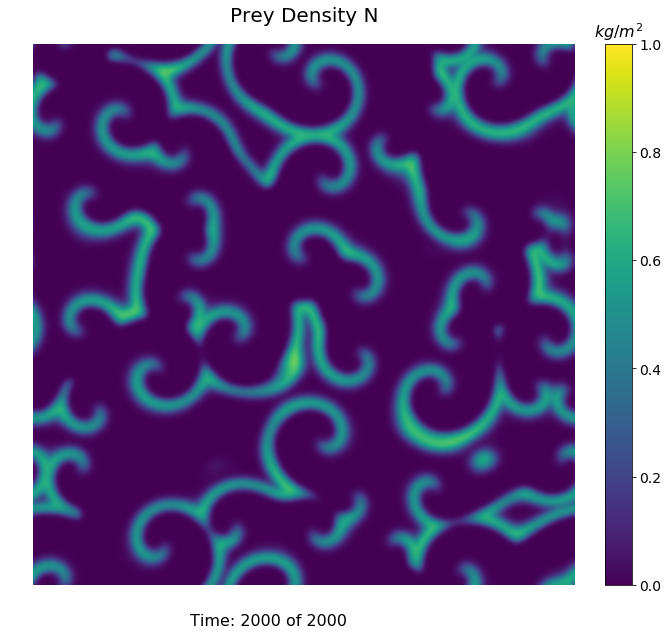

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

im = plt.imshow(Ns[:,:,NumPlots-1].T, animated=True, cmap=None, clim=(0,K),
              interpolation='bilinear')
ax.set_axis_off()
text=fig.suptitle("Time: %1.0f of %1.0f" % ((EndTime, EndTime)), x=0.47, y=0.05, fontsize=16);
ax.set_title('Prey Density N', y=1.03, fontsize=20)

f=fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
f.ax.set_title('$kg/m^2$', fontsize=16)
f.ax.tick_params(labelsize=14)

plt.tight_layout(rect=[0, 0.05, 0.94, 1])
fig.savefig('Predator-Prey Spiral Waves.png', dpi=120)

### Making an animation

In [8]:
from matplotlib import animation, rc

def updatefig(i): # To update the image at each iteration
    global vs
    im.set_array(Ns[:,:,i].T)
    text.set_text("Time: %1.0f of %1.0f" % ((i+1)/NumPlots*EndTime, EndTime));
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=100, frames = NumPlots, repeat=False, blit=True)

### Displaying the animation

In [11]:
from IPython.display import HTML
HTML(ani.to_html5_video())

### Writing movie to file

In [9]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=25, metadata=dict(artist='Me'), bitrate=10000)
ani.save('Predator-Prey Spiral Waves.mp4', writer=writer, dpi=120)

### Plotting global density fluctuations versus time

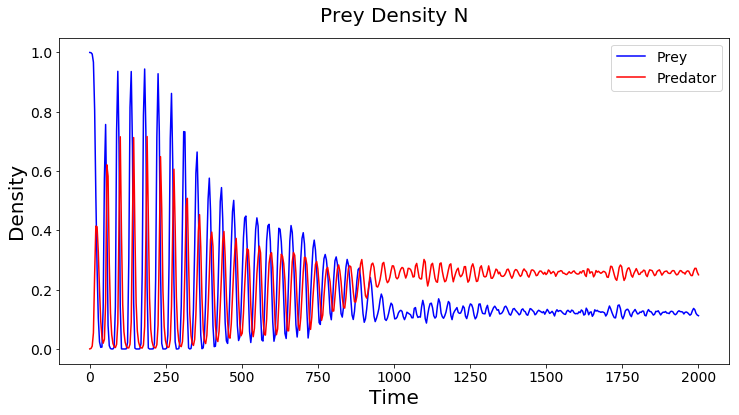

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

T=np.linspace(0,EndTime,NumPlots)

im = plt.plot(T,Nm, color='blue', label='Prey')
im = plt.plot(T,Pm, color='red', label='Predator')
plt.xticks(size = 14); plt.yticks(size = 14)
ax.set_title('Prey Density N', y=1.03, fontsize=20)
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Density', fontsize=20)
ax.legend(fontsize=14);

Copyright Johan van de Koppel, 2018